<a href="https://colab.research.google.com/github/tanmayite94/InsuranceCostPred/blob/master/ML_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [0]:
%%html
<link rel="stylesheet" href="/nbextensions/google.colab/tabbar.css">
<div class='goog-tab'>
  Some content
</div>

In [0]:
import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

class Handler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200)
    # If the response should not be cached in the notebook for
    # offline access:
    # self.send_header('x-colab-notebook-cache-control', 'no-cache')
    self.end_headers()
    self.wfile.write(b'''
      document.querySelector('#output-area').appendChild(document.createTextNode('Script result!'));
    ''')

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Display some HTML referencing the resource.
display(IPython.display.HTML('<script src="https://localhost:{port}/"></script>'.format(port=port)))

In [0]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# get the data
import os
import urllib

download_path = "https://raw.githubusercontent.com/tanmayite94/InsuranceCostPred/master/insurance.csv"

if not os.path.exists('/content/datasets'):
    os.makedirs('/content/datasets')
    file_path = '/content/datasets/insurance.csv'
    urllib.request.urlretrieve(download_path, file_path)

In [0]:
import pandas as pd

insurance = pd.read_csv(file_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [0]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


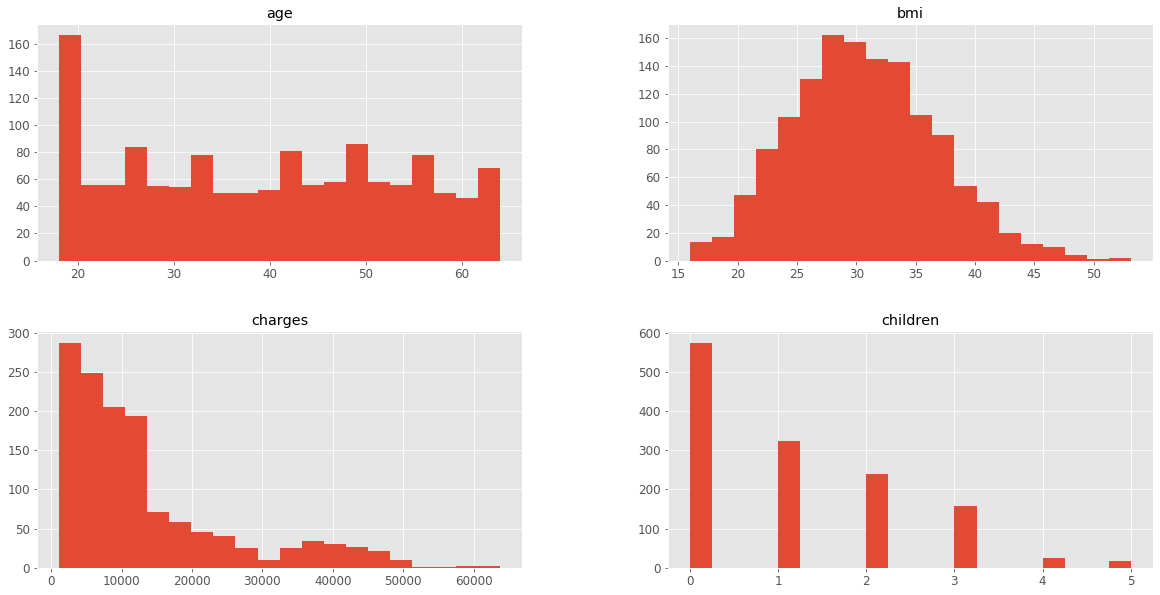

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
insurance.hist(bins=20, figsize=(20, 10))
plt.show()

In [0]:
# split the train set and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

In [0]:
train_set.head()

,age,sex,bmi,children,smoker,region,charges
560,46,female,19.95,2,no,northwest,9193.83850
1285,47,female,24.32,0,no,northeast,8534.67180
1142,52,female,24.86,0,no,southeast,27117.99378
969,39,female,34.32,5,no,southeast,8596.82780
486,54,female,21.47,3,no,northwest,12475.35130


# Visualize Data


In [0]:
colors = []
for item in train_set['smoker']:
    if item == 'yes':
        colors.append('red')
    else:
        colors.append('green')

In the below figure 'red' dots are the people who smoke and 'green' dot are the ones who do not smoke. Figure shows that people who smoke bearing higher charges.

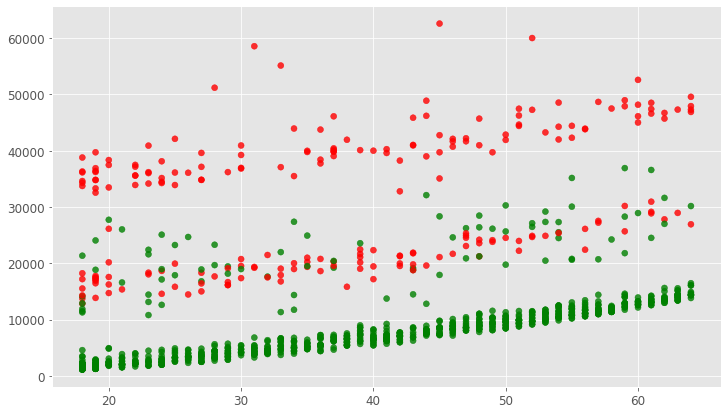

In [0]:
plt.figure(figsize=(12, 7))
plt.scatter(train_set['age'], train_set['charges'], c=colors, alpha=0.8 )
plt.show()

In [0]:
corr_matrix = insurance.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57da7664e0>,
      dtype=object)

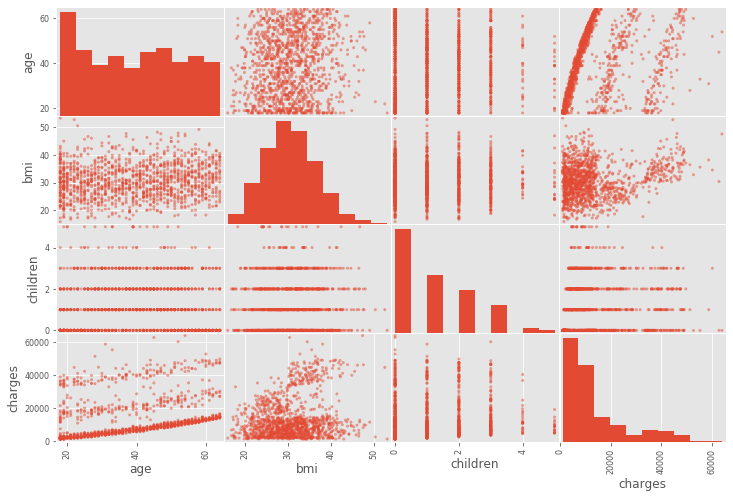

In [0]:
from pandas.plotting import scatter_matrix
scatter_matrix(insurance, figsize=(12, 8))


the scatter matrix show there is not a strong linear relationship between any two numerical attributes so linear regression may not be a good fit here.

In [0]:
# set train, test set aside
insurance = train_set.drop("charges", axis=1)
insurance_labels = train_set["charges"].copy()
insurance_labels.head()

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
Name: charges, dtype: float64

# Preprocessing numerical and text data.

In [0]:
import numpy as np

# separate categorial features from numerical features
insurance_num = list(insurance.select_dtypes(include=[np.number]))
insurance_cat = list(insurance.select_dtypes(include=[np.object]))

In [0]:
# StandardScaler is used for standardization and OneHotEncoder to transform the categorial attributes
# to binary form.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer(
    [('cat', OneHotEncoder(), insurance_cat),
     ('num', StandardScaler(), insurance_num)]
)

insurance_prepared = full_pipeline.fit_transform(insurance)

# save the processed attributes in a list we need it later
cat_attribs = []
temp = full_pipeline.named_transformers_['cat'].categories_ # names of the transformed features
for item in temp:
    for cat in item:
        cat_attribs.append(cat)

num_attribs = full_pipeline.transformers_[1][2]

# Select and train model

In [0]:
# train a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
from sklearn.metrics import mean_squared_error

insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6132.674815701483

In [0]:
# check cross-validation on linear regression
lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6343.01865761 5662.68854609 5988.07811636 6829.18055041 5891.94432448]
Mean: 6142.982038991172
Standard deviation: 407.0823122016718


In [0]:
# let's try a decision tree model
from sklearn.tree import DecisionTreeRegressor

# choose criterion mae because it is less sensitive to outliers than mse.
tree_reg = DecisionTreeRegressor(random_state=42, criterion='mae')

tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
# check mean squared error on decision tree
insurance_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

494.20598375812835

clearly the decision tree model is better fitting the data than linear regression.but we have to evaluate decision tree model first by cross-validation.

In [0]:
# check cross-validation on decision tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [5086.74509404 3962.8200157  4774.78505113 5385.98374953 4762.63065248]
Mean: 4794.592912578376
Standard deviation: 475.04865194713847


Decision tree algorithm was overfitting the data, hence we need to tune the hyperparameters

# Fine tune your model

In [0]:
# try different combinations of hyperparameters
from sklearn.model_selection import GridSearchCV

params_grid = [
              {'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [10, 20, 30, 40]}
               ]

tree_reg = DecisionTreeRegressor(random_state=42, criterion='mae')
grid_search = GridSearchCV(tree_reg, params_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(insurance_prepared, insurance_labels)
grid_search.best_params_

{'max_depth': 8, 'min_samples_leaf': 10}

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5216.176716452528 {'max_depth': 2, 'min_samples_leaf': 10}
5216.176716452528 {'max_depth': 2, 'min_samples_leaf': 20}
5216.176716452528 {'max_depth': 2, 'min_samples_leaf': 30}
5216.176716452528 {'max_depth': 2, 'min_samples_leaf': 40}
4806.317113306886 {'max_depth': 4, 'min_samples_leaf': 10}
4793.923178908624 {'max_depth': 4, 'min_samples_leaf': 20}
4842.5396404645935 {'max_depth': 4, 'min_samples_leaf': 30}
4907.703857134673 {'max_depth': 4, 'min_samples_leaf': 40}
4767.402417291654 {'max_depth': 6, 'min_samples_leaf': 10}
4778.062402204406 {'max_depth': 6, 'min_samples_leaf': 20}
4818.06936636072 {'max_depth': 6, 'min_samples_leaf': 30}
4893.123720634064 {'max_depth': 6, 'min_samples_leaf': 40}
4760.901288622822 {'max_depth': 8, 'min_samples_leaf': 10}
4773.142758150922 {'max_depth': 8, 'min_samples_leaf': 20}
4818.06936636072 {'max_depth': 8, 'min_samples_leaf': 30}
4893.123720634064 {'max_depth': 8, 'min_samples_leaf': 40}


In [0]:
# check feature importance given by algorithm
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = cat_attribs + num_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4050860017732297, 'no'),
 (0.36390407648148815, 'age'),
 (0.20106629966669495, 'bmi'),
 (0.025151643135366615, 'children'),
 (0.002891685472433476, 'female'),
 (0.0007585153276299601, 'northeast'),
 (0.0005450379114953896, 'male'),
 (0.00041319302001163277, 'southeast'),
 (0.00018354721165016213, 'southwest'),
 (0.0, 'yes'),
 (0.0, 'northwest')]

Decision tree gave most importance to the smoker feature and no importance to the region, children, gender features

In [0]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse